##Mounting drive

In [44]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [45]:
# !cd /content/drive/My\ Drive/Thesis/Notebooks
%cd /content/drive/My\ Drive/Thesis/Notebooks
!ls

/content/drive/My Drive/Thesis/Notebooks
 Classifier-Gene-2.ipynb
 Classifier-Gene-2_kernel_width_test.ipynb
 Classifier-Gene.ipynb
 Classifier-Normal-2.ipynb
 Classifier-Normal-2-Kernel_width-Testing.ipynb
 Classifier-Normal.ipynb
'Copy1 of Classifier-Normal-2.ipynb'
'Copy2 of Classifier-Normal-2.ipynb'
'Copy3 of Classifier-Normal-2.ipynb'
 IRelief2.ipynb
 IRelief.ipynb
 Load_dataset.ipynb
 Modified_MultiSurf.ipynb
 Modified_Overlapping_MultiSurf.ipynb
 MultiSurf.ipynb
 Ovelapping_ReliefF.ipynb
 Overlapping_MultiSurf.ipynb
 ReliefF.ipynb
 Relief.ipynb
 RFS.ipynb


##Installing Libraries

In [46]:
!pip install ipynb
!pip install skrebate

##Importing Libraries

In [47]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.neighbors import KNeighborsClassifier
from sklearn.datasets import make_classification
from sklearn.model_selection import train_test_split, RepeatedKFold, RepeatedStratifiedKFold, StratifiedKFold, KFold, LeaveOneOut
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, precision_recall_fscore_support
from sklearn.svm import SVC
from sklearn.pipeline import make_pipeline
from skrebate import ReliefF, MultiSURF, SURF, SURFstar, MultiSURFstar
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import cross_val_score
from ipynb.fs.full.Load_dataset import load_dataset, get_dataset_names, load_gene_dataset, get_gene_dataset_names
from ipynb.fs.full.ReliefF import ReliefF_configure
from ipynb.fs.full.MultiSurf import MultiSurf_configure
from ipynb.fs.full.Modified_MultiSurf import Modified_MultiSurf_configure
from ipynb.fs.full.RFS import RFS_configure
from ipynb.fs.full.Relief import Relief_configure
from ipynb.fs.full.IRelief import I_Relief_configure
from ipynb.fs.full.IRelief2 import I_Relief2_configure
from ipynb.fs.full.Overlapping_MultiSurf import Overlapping_MultiSurf_configure
from ipynb.fs.full.Modified_Overlapping_MultiSurf import Modified_Overlapping_MultiSurf_configure
from ipynb.fs.full.Ovelapping_ReliefF import Ovelapping_ReliefF_configure
from os import path
import time

In [48]:
folderPath = '/content/drive/My Drive/Thesis/Results'
randomState = 123
plt.rc('xtick',labelsize=15)
plt.rc('ytick',labelsize=15)
plotStyles = {
      'markers' : ["o","^","*","s","P","X","d", "p", "H","D"],
      'color' : ['#273c75', '#6c5ce7', '#d63031', '#00b894','#00cec9',  '#0984e3', '#74b9ff', '#6ab04c', '#e056fd', '#f9ca24'],
      'lineStyle' : 'solid',
      'markerSize' :  10,
  }

## Load Dataset

In [49]:
def dataset_preparetion(iterationNum, dName, dataset_dict, noisePercentage = 0, datasetType= 'normal'):
  global randomState, folderPath
  # print('datasetType= ',datasetType)
  X = dataset_dict['attributes']
  Y = dataset_dict['target']
  categoricalX = dataset_dict['categoricalX']
  trainSize = dataset_dict['trainSize']
  testSize = dataset_dict['testSize']
  featureNames = dataset_dict['featureNames']
  # print("Before : ", X.shape, Y.shape)

  # Adding irrelavant Features
  mu, sigma = 0, 5 # mean and standard deviation
  np.random.seed(randomState)
  irrelevantFeatures = np.random.normal(mu, sigma, (X.shape[0], 50))
  X = np.concatenate((X, irrelevantFeatures), axis=1)
  # print("After : ", X.shape, Y.shape)  
  
  XTrain, XTest, YTrain, YTest = train_test_split(X, Y, train_size = trainSize, test_size= testSize, stratify=Y, random_state=randomState+iterationNum)

  # Adding noise i.e. misslabeling training data
  if noisePercentage > 0:
    classes = np.unique(YTrain)

    numOfMislabels = np.floor(len(YTrain) * (noisePercentage/100)).astype(int)
    # print(numOfMislabels)

    # Choose the random instances
    rndIdx = np.random.choice(len(YTrain), numOfMislabels, replace=False)   # random indices of m instances from total of n instances
    # print(rndIdx)

    for idx in rndIdx:
      restOfTheClasses = classes[classes != YTrain[idx]]
      YTrain[idx] = restOfTheClasses[np.random.choice(len(restOfTheClasses), 1, replace=False).item()]
      # print("before : ", Y[idx])
      # print('after : ', newLabel) 

  return XTrain, XTest, YTrain, YTest, categoricalX, featureNames

##Preprocessing and Feature Selection

In [50]:
def feature_selection(X, Y, methods, K_RFS = 7, K_ReliefF = 10, theta_RFS = 3, numUpdates='all', numOfIterations= 5, prior='uniform', categoricalX='off', kernelWidth = 5, theta_IRelief = 1e-9): 
  cache = {}
  if 'RFS' in methods:
    cache['RFS'] = RFS_configure(X,Y, K = K_RFS, theta= theta_RFS)
  
  isBinary = len(np.unique(Y)) == 2
  if 'Relief' in methods:
    if isBinary:
       cache['Relief'] = Relief_configure(X,Y, numUpdates=numUpdates, categoricalX=categoricalX)
  
  if 'ReliefF' in methods:
    start = time.time()
    cache['ReliefF'] = ReliefF_configure(X, Y, K=K_ReliefF, prior=prior, numUpdates=numUpdates, categoricalX=categoricalX) 
    print('ReliefF run time= ',time.time()-start)
 
  if 'IRelief' in methods:
    start = time.time()
    cache['IRelief'] = I_Relief_configure(X, Y, numOfIterations=numOfIterations, categoricalX = categoricalX, kernelWidth = kernelWidth, theta = theta_IRelief, prior=prior)
    print('IRelief run time= ',time.time()-start)

  if 'IRelief2' in methods:
    start = time.time()
    cache['IRelief2'] = I_Relief2_configure(X, Y, numOfIterations=numOfIterations, categoricalX = categoricalX, kernelWidth = kernelWidth, theta = theta_IRelief)
    print('IRelief2 run time= ',time.time()-start)

  if 'MultiSurf' in methods:
    start = time.time()
    cache['MultiSurf'] = MultiSurf_configure(X,Y,prior=prior, numUpdates=numUpdates, categoricalX=categoricalX)
    print('MultiSurf run time= ',time.time()-start)

  if 'Modified_MultiSurf' in methods:
    start = time.time()
    cache['Modified_MultiSurf'] = Modified_MultiSurf_configure(X,Y,prior=prior, numUpdates=numUpdates, categoricalX=categoricalX, kernelWidth = kernelWidth)
    print('Modified_MultiSurf run time= ',time.time()-start)

  if 'Overlapping_MultiSurf' in methods:
    start = time.time()
    cache['Overlapping_MultiSurf'] = Overlapping_MultiSurf_configure(X,Y,prior=prior, numUpdates=numUpdates, categoricalX=categoricalX, kernelWidth = kernelWidth)
    print('Overlapping_MultiSurf run time= ',time.time()-start)

  if 'Modified_Overlapping_MultiSurf' in methods:
    start = time.time()
    cache['Modified_Overlapping_MultiSurf'] = Modified_Overlapping_MultiSurf_configure(X,Y,prior=prior, numUpdates=numUpdates, categoricalX=categoricalX, kernelWidth = kernelWidth)
    print('Modified_Overlapping_MultiSurf run time= ',time.time()-start)

  # for kernel widh choose **********************************************************************
  if 'Modified_Overlapping_MultiSurf_0.05' in methods:
    start = time.time()
    cache['Modified_Overlapping_MultiSurf_0.05'] = Modified_Overlapping_MultiSurf_configure(X,Y,prior=prior, numUpdates=numUpdates, categoricalX=categoricalX, kernelWidth = 0.05)
    print('Modified_Overlapping_MultiSurf_0.05 run time= ',time.time()-start)

  if 'Modified_Overlapping_MultiSurf_0.3' in methods:
    start = time.time()
    cache['Modified_Overlapping_MultiSurf_0.3'] = Modified_Overlapping_MultiSurf_configure(X,Y,prior=prior, numUpdates=numUpdates, categoricalX=categoricalX, kernelWidth = 0.3)
    print('Modified_Overlapping_MultiSurf_0.3 run time= ',time.time()-start)

  if 'Modified_Overlapping_MultiSurf_1' in methods:
    start = time.time()
    cache['Modified_Overlapping_MultiSurf_1'] = Modified_Overlapping_MultiSurf_configure(X,Y,prior=prior, numUpdates=numUpdates, categoricalX=categoricalX, kernelWidth = 1)
    print('Modified_Overlapping_MultiSurf_1 run time= ',time.time()-start)

  if 'Modified_Overlapping_MultiSurf_3' in methods:
    start = time.time()
    cache['Modified_Overlapping_MultiSurf_3'] = Modified_Overlapping_MultiSurf_configure(X,Y,prior=prior, numUpdates=numUpdates, categoricalX=categoricalX, kernelWidth = 3)
    print('Modified_Overlapping_MultiSurf_3 run time= ',time.time()-start)

  if 'Modified_Overlapping_MultiSurf_5' in methods:
    start = time.time()
    cache['Modified_Overlapping_MultiSurf_5'] = Modified_Overlapping_MultiSurf_configure(X,Y,prior=prior, numUpdates=numUpdates, categoricalX=categoricalX, kernelWidth = 5)
    print('Modified_Overlapping_MultiSurf_5 run time= ',time.time()-start)

  if 'Modified_Overlapping_MultiSurf_10' in methods:
    start = time.time()
    cache['Modified_Overlapping_MultiSurf_10'] = Modified_Overlapping_MultiSurf_configure(X,Y,prior=prior, numUpdates=numUpdates, categoricalX=categoricalX, kernelWidth = 10)
    print('Modified_Overlapping_MultiSurf_10 run time= ',time.time()-start)

  # *********************************************************************************************

  if 'Overlapping_ReliefF' in methods:
    start = time.time()
    cache['Overlapping_ReliefF'] = Ovelapping_ReliefF_configure(X,Y,K=K_ReliefF,prior=prior, numUpdates=numUpdates, categoricalX=categoricalX, kernelWidth=kernelWidth)
    print('Overlapping_ReliefF run time= ',time.time()-start)

  if 'ReBATE_ReliefF' in methods:
    start = time.time()
    reliefF = ReliefF(n_features_to_select=min(X.shape[1], 1000), n_neighbors=K_ReliefF)
    reliefF.fit(X, Y)
    weight = reliefF.feature_importances_
    ranked = reliefF.top_features_
    cache['ReBATE_ReliefF'] = ranked, weight
    print('ReBATE_ReliefF run time= ',time.time()-start)

  if 'ReBATE_SURF' in methods:
    start = time.time()
    surf = SURF(n_features_to_select=min(X.shape[1], 1000))
    surf.fit(X, Y)
    weight = surf.feature_importances_
    ranked = surf.top_features_
    cache['ReBATE_SURF'] = ranked, weight
    print('ReBATE_SURF run time= ',time.time()-start)

  if 'ReBATE_SURFstar' in methods:
    start = time.time()
    surfStar = SURFstar(n_features_to_select=min(X.shape[1], 1000))
    surfStar.fit(X, Y)
    weight = surfStar.feature_importances_
    ranked = surfStar.top_features_
    cache['ReBATE_SURFstar'] = ranked, weight
    print('ReBATE_SURFstar run time= ',time.time()-start)

  if 'ReBATE_MultiSURFstar' in methods:
    start = time.time()
    multiSurfStar = MultiSURFstar(n_features_to_select=min(X.shape[1], 1000))
    multiSurfStar.fit(X, Y)
    weight = multiSurfStar.feature_importances_
    ranked = multiSurfStar.top_features_
    cache['ReBATE_MultiSURFstar'] = ranked, weight
    print('ReBATE_MultiSURFstar run time= ',time.time()-start)

  if 'ReBATE_MultiSURF' in methods:
    start = time.time()
    multiSurf = MultiSURF(n_features_to_select=min(X.shape[1], 1000))
    multiSurf.fit(X, Y)
    weight = multiSurf.feature_importances_
    ranked = multiSurf.top_features_
    cache['ReBATE_MultiSURF'] = ranked, weight
    print('ReBATE_MultiSURF run time= ',time.time()-start)  

  return cache

In [51]:
# print('ranked')
# print(ranked)
# print('Rvalue')
# print(Rvalue[np.array(ranked, dtype=int)])

In [52]:
# print('ranked')
# print(reliefF_ranked)
# print('reliefF_weight')
# print(reliefF_weight[np.array(reliefF_ranked, dtype=int)])

##Feature Scaling

In [53]:
def feature_scaling(XTrain, XTest):
  scaler = StandardScaler()
  scaler.fit(XTrain)
  # print("Mean :",scaler.mean_, "Var :", scaler.var_)

  XTrain = scaler.transform(XTrain)
  XTest = scaler.transform(XTest)

  return XTrain, XTest, scaler

##KNN classification

In [54]:
def KNN_classifier(XTrain, YTrain, XTest, YTest, Num_neighbors=7):
  classifier = KNeighborsClassifier(n_neighbors=Num_neighbors)
  classifier.fit(XTrain, YTrain)  
  Y_pred = classifier.predict(XTest)
  score = accuracy_score(YTest, Y_pred)
  # score1 = classifier.score(XTest, YTest)
  # print(score,score1)
  
  return Y_pred, score

##SVM classification

In [55]:
def SVM_classifier(XTrain, YTrain, XTest, YTest, kernel='linear', degree=3):
  # degree is for polynomial kernel
  svclassifier = SVC(kernel=kernel)
  svclassifier.fit(XTrain, YTrain)
  Y_pred = svclassifier.predict(XTest)
  score = accuracy_score(YTest, Y_pred)

  return Y_pred, score

##Evaluataion

In [56]:
def evaluation(YTest, Y_pred):
  print(confusion_matrix(YTest, Y_pred))
  print(classification_report(YTest, Y_pred))

##Classification

In [57]:
def classification(XTrain, XTest, YTrain, YTest, ranked, algo, featureRange, datasetName, Num_neighbors=7, kernel='linear', degree=3):

  scoreCollection = np.array([])
  YPredCollection = []
  XTrain, XTest, _ = feature_scaling(XTrain, XTest)

  for n in featureRange:
    feature_idx = np.array(ranked[0:n])
    
    # if np.sum(feature_idx>=XTrain.shape[1]-50):
    #   print('irrelevent selected: ',feature_idx)
    # print(feature_idx)
    
    # print(feature_idx)
    scores = np.array([])
    XSubTrain, XSubTest = XTrain[:, feature_idx], XTest[:, feature_idx]
    
    # print("XSubTRAIN:", XSubTrain.shape, "XSubTEST:", XSubTest.shape)
    # print("YTRAIN:", YTrain.shape, "YTEST:", YTest.shape)

    if algo == 'KNN':
      YPred, score = KNN_classifier(XSubTrain, YTrain, XSubTest, YTest,  Num_neighbors=Num_neighbors)
    else:
      YPred, score = SVM_classifier(XSubTrain, YTrain, XSubTest, YTest, kernel=kernel, degree=degree)

    scoreCollection = np.append(scoreCollection, score)
    YPredCollection.append(YPred)

  # print(datasetName, scoreCollection)
  return np.array(YPredCollection), scoreCollection

## Run and Save results

In [58]:
def performanceFileWrite(metricName, arrayCollection, index, featureRange, dName, classifierName, isNoisy ): 
  global folderPath 
  filePath = ""
  if isNoisy:
    filePath = folderPath  +  '/Normal/Performance/{}/{}_{}_withNoise.csv'.format(metricName, dName, classifierName)
  else:
    filePath = folderPath  +  '/Normal/Performance/{}/{}_{}_withoutNoise.csv'.format(metricName, dName, classifierName)
  if path.exists(filePath):
    df = pd.read_csv(filePath, sep=",", index_col=['Method', 'Classes'])
    for i in range(index.to_series().nunique()):
      df.loc[index[i],:] = arrayCollection[i] 
  else:
    df = pd.DataFrame(arrayCollection, index=index, columns=featureRange)
    df = df.rename_axis('#features', axis='columns')
 
  print("{} for the dataset {} and classifier {} (Noisy = {})".format(metricName ,dName, classifierName, isNoisy))
  print(df)
  df.to_csv(filePath, sep=",")

In [59]:
def performanceReport(methods, YActual, YPredDict, featureRange, dName, isNoisy, classifierName):
  
  truePosPlusSupportArrayCollection = []
  precisionArrayCollection, recallArrayCollection, f1scoreArrayCollection = [], [], []
  for method in methods: 
    truePosPlusSupportDict = {}
    precisionDict, recallDict, f1scoreDict = {}, {}, {}
    for YPred in YPredDict[method]:
      confMat = confusion_matrix(YActual, YPred)
      precision, recall, f1score, _ = precision_recall_fscore_support(YActual, YPred, average=None)
      truePositives = np.diag(confMat) 
      support = np.sum(confMat, axis = 1) 
      for i in range(len(truePositives)):
        if i not in truePosPlusSupportDict:
          truePosPlusSupportDict[i] = np.array(['A={},TP={}'.format(support[i], truePositives[i])])
          precisionDict[i] = np.array(precision[i])
          recallDict[i] = np.array(recall[i])
          f1scoreDict[i] = np.array(f1score[i])
        else:
          truePosPlusSupportDict[i] = np.append(truePosPlusSupportDict[i], 'A={},TP={}'.format(support[i], truePositives[i]))
          precisionDict[i] = np.append(precisionDict[i], precision[i])
          recallDict[i] = np.append(recallDict[i], recall[i])
          f1scoreDict[i] = np.append(f1scoreDict[i], f1score[i])

    truePosPlusSupportArray = []
    precisionArray, recallArray, f1scoreArray = [], [], []
    for key in truePosPlusSupportDict:
      truePosPlusSupportArray.append(truePosPlusSupportDict[key])
      precisionArray.append(precisionDict[key])
      recallArray.append(recallDict[key])
      f1scoreArray.append(f1scoreDict[key])
    truePosPlusSupportArrayCollection = truePosPlusSupportArrayCollection + truePosPlusSupportArray
    precisionArrayCollection = precisionArrayCollection + precisionArray
    recallArrayCollection = recallArrayCollection + recallArray
    f1scoreArrayCollection = f1scoreArrayCollection + f1scoreArray

  truePosPlusSupportArrayCollection = np.array(truePosPlusSupportArrayCollection)
  precisionArrayCollection = np.array(precisionArrayCollection)
  recallArrayCollection = np.array(recallArrayCollection)
  f1scoreArrayCollection = np.array(f1scoreArrayCollection)
  
  classes = np.unique(YActual)
  # Confusion matrix
  index = pd.MultiIndex.from_product([methods, classes], names=['Method', 'Classes'])

  performanceFileWrite('ConfusionMatrix', truePosPlusSupportArrayCollection, index, featureRange, dName, classifierName, isNoisy )
  performanceFileWrite('Precision', precisionArrayCollection, index, featureRange, dName, classifierName, isNoisy )
  performanceFileWrite('Recall', recallArrayCollection, index, featureRange, dName, classifierName, isNoisy )
  performanceFileWrite('F1score', f1scoreArrayCollection, index, featureRange, dName, classifierName, isNoisy )

### Feature weight calculating

In [60]:
def run_and_save_feature_weights(methods, dName, datasetType='normal', noisePercentage=0, numOfIteration = 20, numOfPoints = 20, numOfFolds = 10, numOfRepeats = 5):
  global randomState, folderPath

  # print('in run_and_save_output datasetType= ',datasetType)
  isNoisy = noisePercentage > 0
  noiseExtension = 'withNoise' if isNoisy else 'withoutNoise'

  dataset_dict =   load_dataset(dName) if (datasetType == 'normal') else load_gene_dataset(dName) 
  # print('datasetType= ',datasetType)

  weightsOfMethods = {}
  ranksOfMethods = {}

  minItrSaved = 1e9
  dfPrevWeights, dfPrevRanks= {}, {}
  # Load the pre saved iteration for each methods
  for method in methods:
    weigthFileExists = path.exists(folderPath  +  '/Normal/Weights/{}/{}_{}.csv'.format(dName, method, noiseExtension))
    rankFileExists = path.exists(folderPath  +  '/Normal/Ranks/{}/{}_{}.csv'.format(dName, method, noiseExtension))
    if weigthFileExists:
      dfPrevWeights[method] = pd.read_csv(folderPath  +  '/Normal/Weights/{}/{}_{}.csv'.format(dName, method, noiseExtension), sep=",",index_col="Iterations", header=0)
      minItrSaved = min(minItrSaved, dfPrevWeights[method].index.shape[0]-1)
    else:
      minItrSaved = 0

    if rankFileExists:
      dfPrevRanks[method] = pd.read_csv(folderPath  +  '/Normal/Ranks/{}/{}_{}.csv'.format(dName, method, noiseExtension), sep=",",index_col="Iterations", header=0)
      minItrSaved = min(minItrSaved, dfPrevRanks[method].index.shape[0]-1)
    else:
      minItrSaved = 0

  for iterationNo in range(numOfIteration):
    XTrain, XTest, YTrain, YTest, categoricalX, featureNames = dataset_preparetion(iterationNo, dName, dataset_dict, noisePercentage, datasetType)

    # Here if we estimate best K for KNN classification using 10 fold stratified cross validation, it will help us to do comparison more fairly.
    # Here If we estimate best kernelWidth sigma for I-Relief using 10 fold stratified cross validation, it will help us to do comparison more fairly. 
    # Here If we estimate best K(i.e. number of nearest hits and misses) for Relief-F using 10 fold stratified cross validation, it will help us to do comparison more fairly. 


    # performing feture selection 
    # Using kernelwidth sigma = 3 and number of iterations = 20 and convergence_threshold = 1e-5 for I-Relief-1 and I-Relief-2
    # Using number of nearest hits and misses i.e. K = 10 for ReliefF and also using all the training data for Relief and ReliefF
    # Using number of nearest Neighbours k = 7 and overlapping_threshold = 3 for RFS
    # print('Training data size: training examples = {}, features= {}'.format(XTrain.shape[0], XTrain.shape[1]))
    
    cache = {}
    if iterationNo >= minItrSaved:
      # Feature Selection
      cache = feature_selection(XTrain, YTrain, methods, K_RFS = 7, K_ReliefF = 10, theta_RFS = 3, numUpdates='all', numOfIterations = 20, prior='empirical', categoricalX='off', kernelWidth = 5, theta_IRelief = 1e-5)
  
    for method in methods:
      ranked, weight= None, None
      if iterationNo>=minItrSaved:
        ranked, weight = cache[method]        
      else:
        ranked, weight = dfPrevRanks[method].loc[iterationNo,:].to_numpy(), dfPrevWeights[method].loc[iterationNo,:].to_numpy()

      if method not in weightsOfMethods:
        weightsOfMethods[method] = [weight]
        ranksOfMethods[method] = [ranked]
      else:
        weightsOfMethods[method].append(weight)
        ranksOfMethods[method].append(ranked)

      if iterationNo == minItrSaved:
        print('iterationNo = ', iterationNo)
        dfWeights, dfRanks = None, None
        if featureNames.shape[0] == 0:
          dfWeights = pd.DataFrame(np.array(weightsOfMethods[method]))
          dfRanks = pd.DataFrame(np.array(ranksOfMethods[method]))
        else:
          dfWeights = pd.DataFrame(np.array(weightsOfMethods[method]), columns=featureNames)
          dfRanks = pd.DataFrame(np.array(ranksOfMethods[method]), columns=featureNames)

        dfWeights = dfWeights.rename_axis('Iterations', axis='index').rename_axis('Features', axis = 'columns')
        dfWeights.to_csv(folderPath + '/Normal/Weights/{}/{}_{}.csv'.format(dName,method, noiseExtension), sep=",")

        dfRanks = dfRanks.rename_axis('Iterations', axis='index').rename_axis('Features', axis = 'columns')
        dfRanks.to_csv(folderPath + '/Normal/Ranks/{}/{}_{}.csv'.format(dName,method, noiseExtension), sep=",")
      
      elif iterationNo > minItrSaved:
        print('iterationNo = ', iterationNo)
        newDfWeights = pd.DataFrame(np.array([weight]), index=[iterationNo])
        newDfRanks = pd.DataFrame(np.array([ranked]), index=[iterationNo])

        newDfWeights.to_csv(folderPath + '/Normal/Weights/{}/{}_{}.csv'.format(dName,method, noiseExtension), sep=",", mode='a', header = False)
        newDfRanks.to_csv(folderPath + '/Normal/Ranks/{}/{}_{}.csv'.format(dName,method, noiseExtension), sep=",", mode='a', header = False) 

  # saving avg weigts of all methods
  avgWeightsOfMethods ={}
  for method in methods:
    weightsOfMethods[method] = np.array(weightsOfMethods[method])
    avgWeights = np.sum(weightsOfMethods[method],axis=0)/numOfIteration
    avgWeightsOfMethods[method]=avgWeights

  dfAvgWeights = None
  if path.exists(folderPath+ '/Normal/Weights/{}/avgWeights_{}.csv'.format(dName, noiseExtension)):
    dfAvgWeights = pd.read_csv(folderPath + '/Normal/Weights/{}/avgWeights_{}.csv'.format(dName, noiseExtension), sep=",", index_col="Methods", header=0)
    for method in methods:
      dfAvgWeights.loc[method] = avgWeightsOfMethods[method]
  else:
    if featureNames.shape[0]==0:
      dfAvgWeights= pd.DataFrame.from_dict(avgWeightsOfMethods, orient='index')
    else:
      dfAvgWeights= pd.DataFrame.from_dict(avgWeightsOfMethods, orient='index', columns=featureNames)
  dfAvgWeights = dfAvgWeights.rename_axis('Methods', axis='index').rename_axis('Features', axis = 'columns')
  dfAvgWeights.to_csv(folderPath + '/Normal/Weights/{}/avgWeights_{}.csv'.format(dName, noiseExtension), sep=",")
  


### Run classification

In [61]:
def run_and_save_output(methods, dName, datasetType='normal', noisePercentage=0, numOfIteration = 20, numOfPoints = 20, numOfFolds = 10, numOfRepeats = 5):
  global randomState, folderPath
  # print('in run_and_save_output datasetType= ',datasetType)
  isNoisy = noisePercentage > 0
  noiseExtension = 'withNoise' if isNoisy else 'withoutNoise'

  totalSvmScores = 0
  totalKnnScores = 0

  dataset_dict =   load_dataset(dName) if (datasetType == 'normal') else load_gene_dataset(dName) 
  # print('datasetType= ',datasetType)

  X = dataset_dict['attributes'] 

  featureRange = np.unique(np.linspace(1, X.shape[1],  numOfPoints, dtype=int))
  # print(featureRange)

  YActual = np.array([])
  YPredSVMDict = {}
  YPredKNNDict = {}
  YCollected= False

  svmScoresList = []
  knnScoresList = []

  knnScoreCollection = [] # Store the accuracy for each iteration for each kernel width(sigma)
  sigmaCollection = []
  
  for method in methods:
    df = pd.read_csv(folderPath  +  '/Normal/Ranks/{}/{}_{}.csv'.format(dName, method,noiseExtension), sep=",",index_col="Iterations", header=0)
    featureNames = df.columns.to_numpy() #featureNames in an array
    ranks = df.to_numpy() #feature ranks of each iteration in each rows of ranks array

    sigma = method
    if sigma.find('Modified_Overlapping_MultiSurf_') != -1:
      sigma= sigma.replace('Modified_Overlapping_MultiSurf_', '')

    svmScores = 0
    knnScores = 0
    for itrationNo in range(numOfIteration):
      XTrain, XTest, YTrain, YTest, categoricalX, featureNames = dataset_preparetion(itrationNo, dName, dataset_dict, noisePercentage, datasetType)
      if not YCollected:
        YActual = np.append(YActual, YTest) 

      # Here if we estimate best K for KNN classification using 10 fold stratified cross validation, it will help us to do comparison more fairly.
      # Here If we estimate best kernelWidth sigma for I-Relief using 10 fold stratified cross validation, it will help us to do comparison more fairly. 
      # Here If we estimate best K(i.e. number of nearest hits and misses) for Relief-F using 10 fold stratified cross validation, it will help us to do comparison more fairly. 


      # performing feture selection 
      # Using kernelwidth sigma = 5 and number of iterations = 20 and convergence_threshold = 1e-5 for I-Relief-1 and I-Relief-2
      # Using number of nearest hits and misses i.e. K = 10 for ReliefF and also using all the training data for Relief and ReliefF
      # Using number of nearest Neighbours k = 7 and overlapping_threshold = 3 for RFS
      # print('Training data size: training examples = {}, features= {}'.format(XTrain.shape[0], XTrain.shape[1]))

      svmYPred, svmScore = classification(XTrain, XTest, YTrain, YTest, ranks[itrationNo], algo = 'SVM', featureRange = featureRange, datasetName = dName, kernel='linear', degree=3)
      knnYPred, knnScore = classification(XTrain, XTest, YTrain, YTest, ranks[itrationNo], algo = 'KNN', featureRange = featureRange, datasetName = dName, Num_neighbors=7)
      svmScores += svmScore
      knnScores += knnScore  
      if method not in YPredSVMDict:
        YPredSVMDict[method] = svmYPred
        YPredKNNDict[method] = knnYPred
      else:
        YPredSVMDict[method] = np.append(YPredSVMDict[method], svmYPred, axis = 1)
        YPredKNNDict[method] = np.append(YPredKNNDict[method], knnYPred, axis = 1)

      # For stastical analysis purpose
      knnScoreCollection.append(knnScore)
      sigmaCollection.append(sigma)
    
    svmScoresList.append(svmScores)  #summation of svmScores for each method is appending in svmScoresList
    knnScoresList.append(knnScores)  #summation of knnScores for each method is appending in knnScoresList
    YCollected= True

  avgSvmScores = np.array(svmScoresList)/numOfIteration
  avgKnnScores = np.array(knnScoresList)/numOfIteration

  classifiers = np.array(['KNN', 'SVM'])
  # print(classifiers.shape, methods.shape)
  # print(svmScores.shape, knnScores.shape)
  allScores = np.concatenate((avgKnnScores, avgSvmScores), axis=0)
  index = pd.MultiIndex.from_product([classifiers, methods], names=['Classifier', 'Method'])

  filePath = ""
  if isNoisy:
    filePath = folderPath  +  '/Normal/ClassificationAccuracy/{}_withNoise.csv'.format(dName)
  else:
    filePath = folderPath  +  '/Normal/ClassificationAccuracy/{}_withoutNoise.csv'.format(dName)
  
  if path.exists(filePath):
    df = pd.read_csv(filePath, sep=",", index_col=['Classifier','Method'])
    for i in range(index.to_series().nunique()):
      df.loc[index[i],:] = allScores[i] 
  else:
    df = pd.DataFrame(allScores, index=index, columns=featureRange)
    df = df.rename_axis('#features', axis='columns')

  print("Dataset Name :", dName)    
  print(df)
  df.to_csv(filePath, sep=",")

  # For statistical analysis purpose
  statisticalAnalysisPath = "/content/drive/MyDrive/Thesis/Results/Statistical_Analysis/kernel_width/{}.csv".format(dName)
  df2 = pd.DataFrame(np.array(knnScoreCollection), index=np.array(sigmaCollection), columns=featureRange)
  df2.to_csv(statisticalAnalysisPath, sep=',')

  # Writing precision, recall, f1-score, support to the file
  performanceReport(methods, YActual, YPredSVMDict, featureRange, dName, isNoisy, 'SVM')
  performanceReport(methods, YActual, YPredKNNDict, featureRange, dName, isNoisy, 'KNN')

In [62]:
# def run_and_save_output(dName, datasetType='normal', noisePercentage=0, numOfPoints = 10):
#   # print('in run_and_save_output datasetType= ',datasetType)
#   numOfIteration = 5
#   isNoisy = noisePercentage > 0

#   totalSvmScores = 0
#   totalKnnScores = 0
#   avgWeights = 0

#   dataset_dict =   load_dataset(dName) if (datasetType == 'normal') else load_gene_dataset(dName)
#   YActual = np.array([])
#   YPredSVMDict = {}
#   YPredKNNDict = {}

#   for t in range(numOfIteration):
#     XTrain, XTest, YTrain, YTest, categoricalX = dataset_preparetion(t, dName, dataset_dict, noisePercentage, datasetType)
#     YActual = np.append(YActual, YTest)

#     # # Estimating best K for KNN classification using 10 fold stratified cross validation
#     # kFold = KFold(n_splits=5)
#     # maxScore = -1

#     # # loop thourgh 1 to 20 as the number of nearest neighbours K
#     # for k in range(1,21):

#     #   scores = np.array([])
#     #   for trainIndex, valIndex in kFold.split(XTrain, YTrain):
#     #     xTrn, xVal = XTrain[trainIndex, :], XTrain[valIndex, :]
#     #     yTrn, yVal = YTrain[trainIndex], YTrain[valIndex]
#     #     xTrn, xVal, _ = feature_scaling(xTrn, xVal)

#     #     _, score = KNN_classifier(xTrn, yTrn, xVal, yVal, Num_neighbors=k)

#     #     scores = np.append(scores, score)

#     #   avgScore = np.mean(scores)
#     #   if avgScore > maxScore:
#     #     maxScore = avgScore
#     #     bestK = k

#     # print("Best K to apply KNN in the dataset {} is {}".format(dName, bestK))

#     # Here If we estimate best kernelWidth sigma for I-Relief using 10 fold stratified cross validation, it will help us to do comparison more fairly.
#     # Here If we estimate best K(i.e. number of nearest hits and misses) for Relief-F using 10 fold stratified cross validation, it will help us to do comparison more fairly.


#     # performing feture selection
#     # Using kernelwidth sigma = 3 and number of iterations = 20 and convergence_threshold = 1e-5 for I-Relief-1 and I-Relief-2
#     # Using number of nearest hits and misses i.e. K = 10 for ReliefF and also using all the training data for Relief and ReliefF
#     # Using number of nearest Neighbours k = 7 and overlapping_threshold = 3 for RFS
#     # print('Training data size: training examples = {}, features= {}'.format(XTrain.shape[0], XTrain.shape[1]))
#     cache = feature_selection(XTrain, YTrain, K_RFS = 7, K_ReliefF = 10, theta_RFS = 3, numUpdates='all', numOfIterations = 20, prior='empirical', categoricalX='off', kernelWidth = 3, theta_IRelief = 1e-5)
#     featureRange = np.unique(np.linspace(1, XTrain.shape[1]-50,  numOfPoints, dtype=int))

#     svmScores = []
#     knnScores = []
#     weights = []
#     methods = np.array([])

#     for method, rankWeight in cache.items():
#       ranked, weight = rankWeight
#       # print(method, ranked[:XTrain.shape[1]-50])
#       methods = np.append(methods, method)
#       weights.append(weight)

#       svmYPred, svmScore = classification(XTrain, XTest, YTrain, YTest, ranked, algo = 'SVM', featureRange = featureRange, datasetName = dName, kernel='linear', degree=3)
#       knnYPred, knnScore = classification(XTrain, XTest, YTrain, YTest, ranked, algo = 'KNN', featureRange = featureRange, datasetName = dName, Num_neighbors=7)
#       svmScores.append(svmScore)
#       knnScores.append(knnScore)

#       if method not in YPredSVMDict:
#         YPredSVMDict[method] = svmYPred
#         YPredKNNDict[method] = knnYPred
#       else:
#         YPredSVMDict[method] = np.append(YPredSVMDict[method], svmYPred, axis = 1)
#         YPredKNNDict[method] = np.append(YPredKNNDict[method], knnYPred, axis = 1)

#     svmScores = np.array(svmScores)
#     knnScores = np.array(knnScores)
#     weights = np.array(weights)

#     totalSvmScores = totalSvmScores + svmScores
#     totalKnnScores = totalKnnScores + knnScores
#     avgWeights = avgWeights + weights

#   avgSvmScores = totalSvmScores/np.float(numOfIteration)
#   avgKnnScores = totalKnnScores/np.float(numOfIteration)
#   avgWeights = avgWeights/ np.float(numOfIteration)

#   classifiers = np.array(['KNN', 'SVM'])
#   # print(classifiers.shape, methods.shape)
#   # print(svmScores.shape, knnScores.shape)
#   index = pd.MultiIndex.from_product([classifiers, methods], names=['Classifier', 'Method'])
#   df = pd.DataFrame(np.concatenate((avgKnnScores, avgSvmScores), axis=0), index=index, columns=featureRange)
#   df = df.rename_axis('#features', axis='columns')
#   print("Dataset Name :", dName)
#   print(df)

#   dfWeights = pd.DataFrame(avgWeights, index = methods)
#   dfWeights = dfWeights.rename_axis('Method', axis='index').rename_axis('Feature idx', axis = 'columns')
#   # print(dfWeights)

#   if isNoisy:
#     df.to_csv(folderPath + '/Normal/ClassificationAccuracy/{}_withNoise.csv'.format(dName), sep=",")
#     dfWeights.to_csv(folderPath + '/Normal/Weights/{}_withNoise.csv'.format(dName), sep=",")
#   else:
#     df.to_csv(folderPath + '/Normal/ClassificationAccuracy/{}_withoutNoise.csv'.format(dName), sep=",")
#     dfWeights.to_csv(folderPath + '/Normal/Weights/{}_withoutNoise.csv'.format(dName), sep=",")

#   # Writing precision, recall, f1-score, support to the file
#   performanceReport(methods, YActual, YPredSVMDict, featureRange, dName, isNoisy, 'SVM')
#   performanceReport(methods, YActual, YPredKNNDict, featureRange, dName, isNoisy, 'KNN')


##Plotting Accuracy

In [63]:
def plotting_accuracy(methods, dName):
  global randomState, folderPath, plotStyles

  # extension = ['withoutNoise', 'withNoise']
  extension = ['withoutNoise']
  plt.figure(figsize=(20,10*len(extension)))

  for i in range(len(extension)):
    df = pd.read_csv(folderPath + '/Normal/ClassificationAccuracy/{}_{}.csv'.format(dName, extension[i]), sep=",", index_col=['Classifier','Method'])
    noOfFeatures = np.array(df.columns, dtype=int)
    print("noOfFeatures : ", noOfFeatures)
    classifiers = np.unique(df.index.get_level_values('Classifier'))
    noOfClassifiers = len(classifiers)
    # methods = np.unique(df.index.get_level_values('Method'))
    noOfMethods = len(methods)
    lines = []

    for j in range(noOfClassifiers):
      plt.subplot(len(extension), noOfClassifiers, (noOfClassifiers * (i)) + j + 1).set_title('Dataset: {} {}, Classifier : {} '.format(dName, extension[i], classifiers[j]), fontsize=20)
      plt.ylabel('Accuracy', fontsize=20)
      plt.xlabel('#features', fontsize=20)
      
      takenMethods = methods
      
      # for k in range(noOfMethods):
      #   if methods[k] not in ['Modified_MultiSurf', 'Overlapping_MultiSurf']:
      #     takenMethods.append(methods[k])

      labels = []    
      for k in range(len(takenMethods)):
        label=takenMethods[k]
        # if label == 'Modified_Overlapping_MultiSurf':
        #   label = 'mMultiSURF'
        # elif label == 'ReBATE_MultiSURF':
        #   label = 'MultiSURF'
        if label.find('Modified_Overlapping_MultiSurf_') != -1:
          label= label.replace('Modified_Overlapping_MultiSurf_', r'$\sigma = $')
        labels.append(label)

        line,  = plt.plot(noOfFeatures, df.loc[(classifiers[j], takenMethods[k])], color=plotStyles['color'][k], linestyle=plotStyles['lineStyle'], 
                  marker=plotStyles['markers'][k], markersize=plotStyles['markerSize'], label=label)
        lines.append(line)
          
      plt.legend(lines, labels, prop={'size': 18})
        
  plt.show()


##Plotting ROC

In [64]:
def plotting_roc(dName, noOfPoints=50 ):

  global randomState, folderPath, plotStyles

  # extension = ['withoutNoise', 'withNoise']
  extension = ['withoutNoise']
  plt.figure(figsize=(10*len(extension),10))
  thresholds = np.linspace(0, 1, noOfPoints)

  for i in range(len(extension)):
    df = pd.read_csv(folderPath + '/Normal/Weights/{}_{}.csv'.format(dName, extension[i]), sep=",", index_col=['Method'])  
    # print(df)  
    methods = np.unique(df.index.get_level_values('Method'))
    noOfMethods = len(methods)
    lines = []

    plt.subplot(1, len(extension),  i + 1).set_title('Dataset: {} {}'.format(dName, extension[i]))
    plt.ylabel('num of useful features')
    plt.xlabel('num of useless features')

    for k in range(noOfMethods):
      weights = np.array(df.loc[methods[k]])
      # print(weights)

      usefulFeatures= np.array([])
      uselessFeatures=np.array([])

      for th in thresholds:
        usefulInd = [ i for i in range(len(weights)) if weights[i]>th and i<len(weights)-50]
        uselessInd = [ i for i in range(len(weights)) if weights[i]>th and i>=len(weights)-50]
        usefulFeatures = np.append(usefulFeatures, len(usefulInd))
        uselessFeatures = np.append(uselessFeatures, len(uselessInd))

      # print(usefulFeatures.shape)
      line,  = plt.plot(uselessFeatures, usefulFeatures, color=plotStyles['color'][k], linestyle=plotStyles['lineStyle'], 
      marker=plotStyles['markers'][k], markersize=plotStyles['markerSize'], label=methods[k])
      lines.append(line)  


    plt.legend(lines, methods)
        
  plt.show()


## Plotting Weights

In [65]:
def plotting_weights(methods, dName):

  global randomState, folderPath, plotStyles

  # extension = ['withoutNoise', 'withNoise']
  extension = ['withoutNoise']
  plt.figure(figsize=(10*len(extension), 10* len(methods)))

  for i in range(len(extension)):
    df = pd.read_csv(folderPath + '/Normal/Weights/{}/avgWeights_{}.csv'.format(dName, extension[i]), sep=",", index_col=['Methods'])  
    # print(df)  
    # methods = np.unique(df.index.get_level_values('Method'))
    noOfMethods = len(methods)    

    for j in range(noOfMethods):
      weights = np.array(df.loc[methods[j]])
      # print(weights)

      plt.subplot(noOfMethods, len(extension), j*len(extension) + i + 1).set_title('Dataset: {} {}, method: {}'.format(dName, extension[i], methods[j]))
      plt.ylabel('Feature Weights')
      plt.xlabel('Feature index')

      # print(usefulFeatures.shape)
      line,  = plt.plot(np.arange(len(weights)), weights, color=plotStyles['color'][0], linestyle=plotStyles['lineStyle'], 
      marker=plotStyles['markers'][0], markersize=plotStyles['markerSize'], label=methods[j]) 
        
  plt.show()

# Saving Plots

In [66]:
def save_plot(methods, dName, fileExtension):
  global randomState, folderPath, plotStyles

  # extension = ['withoutNoise', 'withNoise']
  extension = ['withoutNoise']
  plt.figure(figsize=(10,10))

  for i in range(len(extension)):
    df = pd.read_csv(folderPath + '/Normal/ClassificationAccuracy/{}_{}.csv'.format(dName, extension[i]), sep=",", index_col=['Classifier','Method'])
    noOfFeatures = np.array(df.columns, dtype=int)
    classifiers = np.unique(df.index.get_level_values('Classifier'))
    noOfClassifiers = len(classifiers)
    # methods = np.unique(df.index.get_level_values('Method'))
    noOfMethods = len(methods)
    lines = []

    for j in range(noOfClassifiers):
      plt.clf()
      plt.title('Dataset: {} {}, Classifier : {} '.format(dName, extension[i], classifiers[j]), fontsize=20)
      plt.ylabel('Accuracy', fontsize=20)
      plt.xlabel('#features', fontsize=20)
      takenMethods = methods
      # for k in range(noOfMethods):
      #   if methods[k] not in ['Modified_MultiSurf', 'Overlapping_MultiSurf']:
      #     takenMethods.append(methods[k])


      labels = []    
      for k in range(len(takenMethods)):
        label=takenMethods[k]
        # if label == 'Modified_Overlapping_MultiSurf':
        #   label = 'mMultiSURF'
        # elif label == 'ReBATE_MultiSURF':
        #   label = 'MultiSURF'
        if label.find('Modified_Overlapping_MultiSurf_') != -1:
          label= label.replace('Modified_Overlapping_MultiSurf_', r'$\sigma = $')
        labels.append(label)

        line,  = plt.plot(noOfFeatures, df.loc[(classifiers[j], takenMethods[k])], color=plotStyles['color'][k], linestyle=plotStyles['lineStyle'], 
                  marker=plotStyles['markers'][k], markersize=plotStyles['markerSize'], label=label)
        lines.append(line)
          
      plt.legend(lines, labels, prop={'size': 18})  
      plt.savefig(folderPath +'/Normal/Plots/ClassificationAccuracy/{}/{}/{}_kernelWidth.{}'.format(extension[i], classifiers[j], dName, fileExtension))


# Kernel Width Test

In [67]:
methods = np.array(['Modified_Overlapping_MultiSurf_0.05', 'Modified_Overlapping_MultiSurf_0.3', 'Modified_Overlapping_MultiSurf_1', 'Modified_Overlapping_MultiSurf_3', 
                    'Modified_Overlapping_MultiSurf_5', 'Modified_Overlapping_MultiSurf_10' ])

dataset: waveform
instances = 5000, features= 21 
Dataset Name : waveform
                                                       1  ...        21
Classifier Method                                         ...          
KNN        Modified_Overlapping_MultiSurf       0.502696  ...  0.803022
           ReliefF                              0.503348  ...  0.806870
           ReBATE_ReliefF                       0.503348  ...  0.806957
           ReBATE_SURF                          0.499674  ...  0.799761
           ReBATE_SURFstar                      0.335543  ...  0.368750
           ReBATE_MultiSURFstar                 0.391728  ...  0.406891
           ReBATE_MultiSURF                     0.500391  ...  0.771380
           Overlapping_MultiSurf                0.507130  ...  0.802337
SVM        Modified_Overlapping_MultiSurf       0.522804  ...  0.827380
           ReliefF                              0.520076  ...  0.831402
           ReBATE_ReliefF                       0.520076  ... 

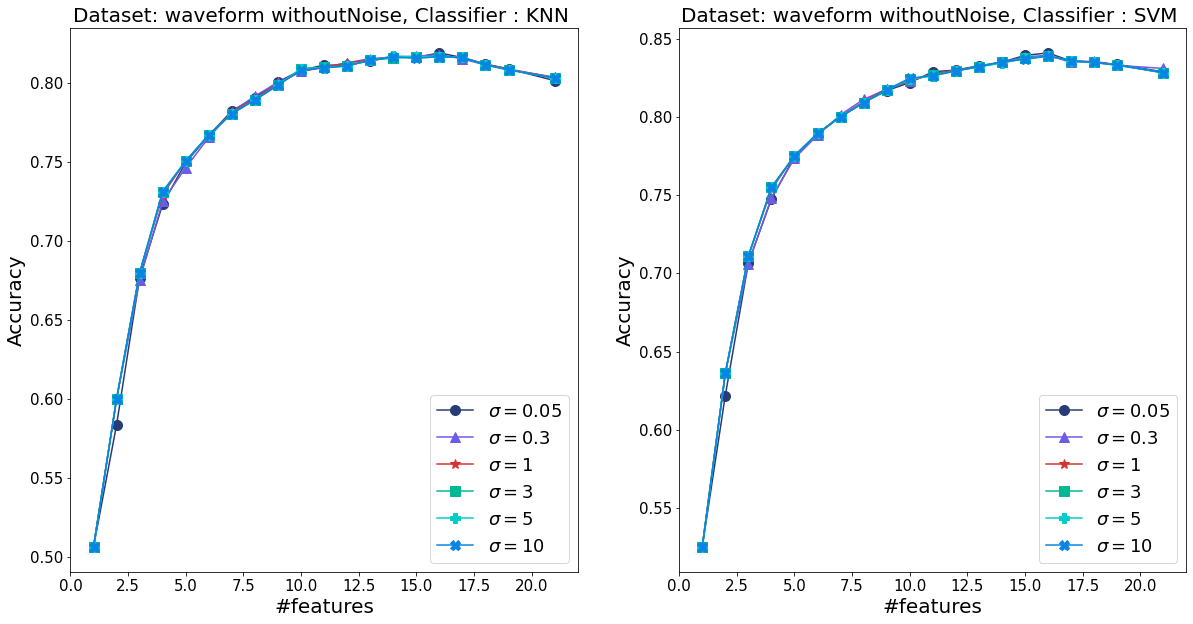

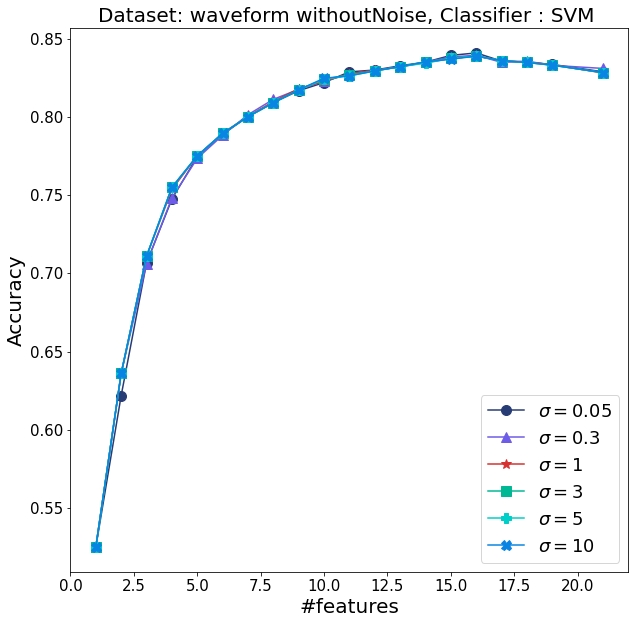

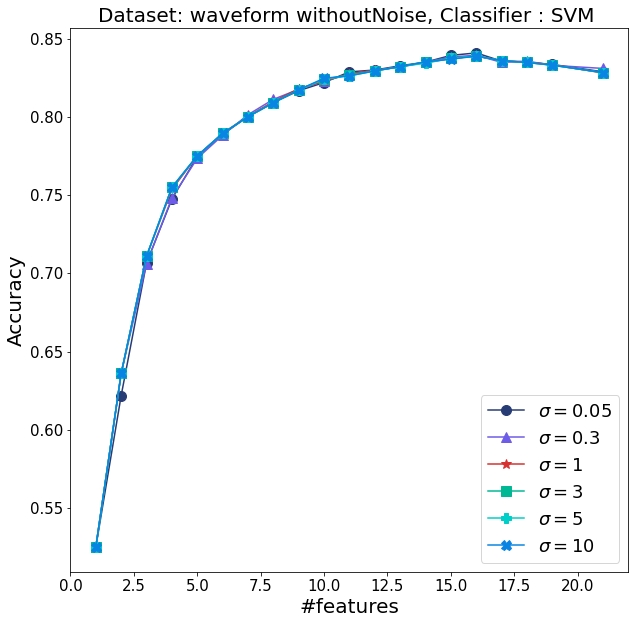

In [68]:
dName = 'waveform'
# run_and_save_feature_weights(methods, dName, numOfIteration = 10)
run_and_save_output(methods, dName, numOfIteration = 10)

plotting_accuracy(methods, 'waveform')
save_plot(methods, 'waveform', 'svg')
save_plot(methods, 'waveform', 'png')
# plotting_roc('waveform')
# plotting_weights(methods, 'waveform')

dataset: wine
instances = 178, features= 13 
dataset: wine
instances = 178, features= 13 
Dataset Name : wine
                                                       1  ...        13
Classifier Method                                         ...          
KNN        ReliefF                              0.738462  ...  0.963462
           Modified_Overlapping_MultiSurf       0.680128  ...  0.957692
           ReBATE_ReliefF                       0.740385  ...  0.962179
           ReBATE_SURF                          0.680769  ...  0.963462
           ReBATE_SURFstar                      0.657692  ...  0.718590
           ReBATE_MultiSURFstar                 0.670513  ...  0.762179
           ReBATE_MultiSURF                     0.680128  ...  0.958333
           Modified_MultiSurf                   0.678205  ...  0.957051
           Overlapping_MultiSurf                0.678846  ...  0.953205
SVM        ReliefF                              0.718590  ...  0.966667
           Modified_Overla

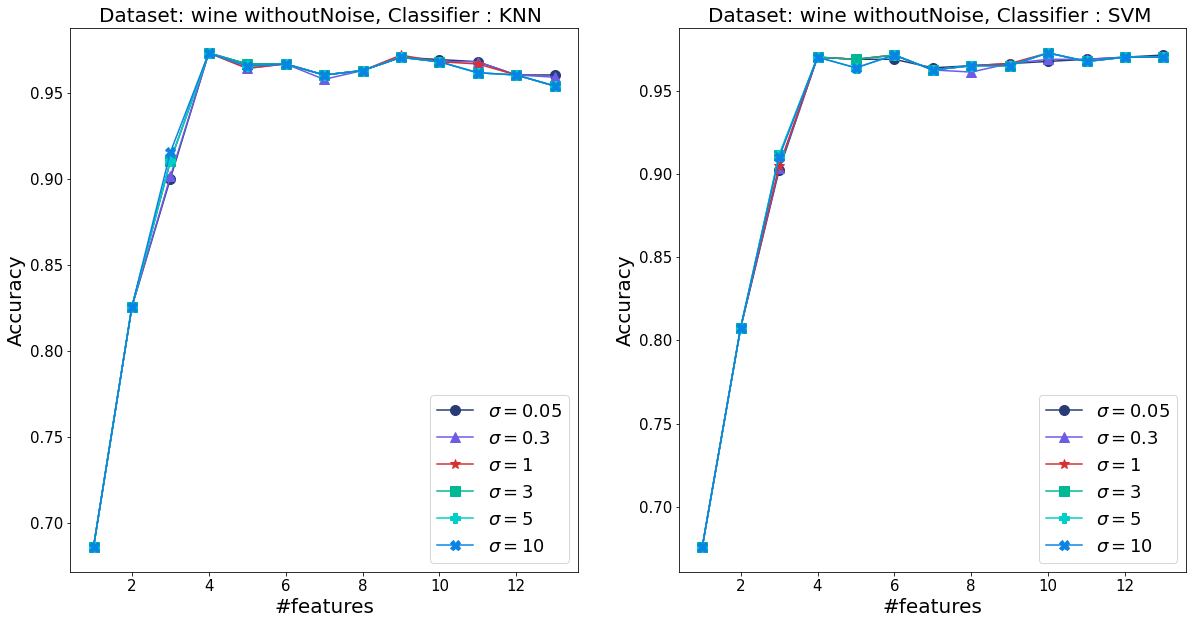

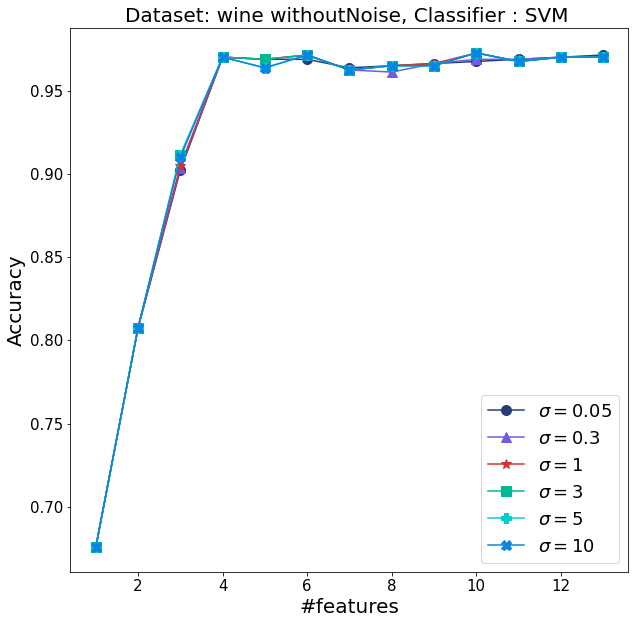

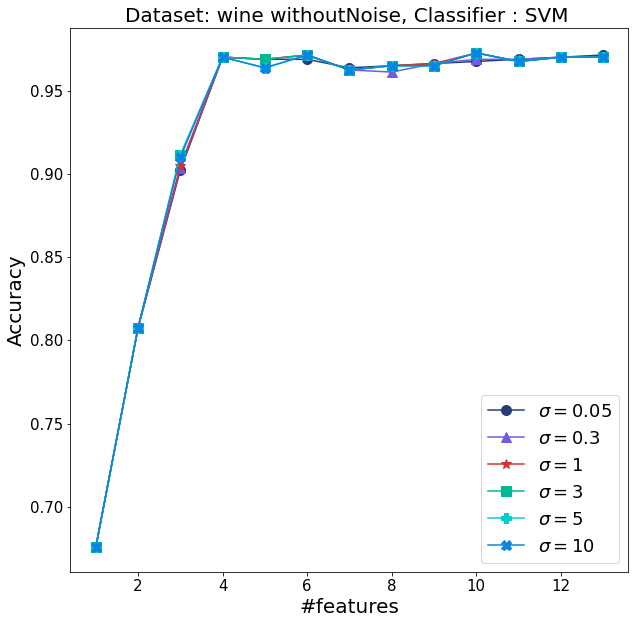

In [69]:
dName = 'wine'
run_and_save_feature_weights(methods, dName, numOfIteration = 10)
run_and_save_output(methods, dName, numOfIteration = 10)

plotting_accuracy(methods, 'wine')
save_plot(methods, 'wine', 'svg')
save_plot(methods, 'wine', 'png')
# plotting_roc('wine')
# plotting_weights(methods, 'wine')

In [ ]:
dName = 'segmentation'
# run_and_save_feature_weights(methods, dName)
# run_and_save_output(methods, dName)

plotting_accuracy(methods, 'segmentation')
save_plot(methods, 'segmentation', 'svg')
save_plot(methods, 'segmentation', 'png')
# plotting_roc('segmentation')
# plotting_weights(methods, 'segmentation')

In [ ]:
data = {'row_1': np.array([[3, 2], [1, 0]]), 'row_2': np.array([['a', 'b'], ['c', 'd']])}
pd.DataFrame.from_dict(data, orient='index')